# Trabajo Semanal 4
### Autor: Arturo Huber

Hago una entrega parcial con el codigo y los resultados

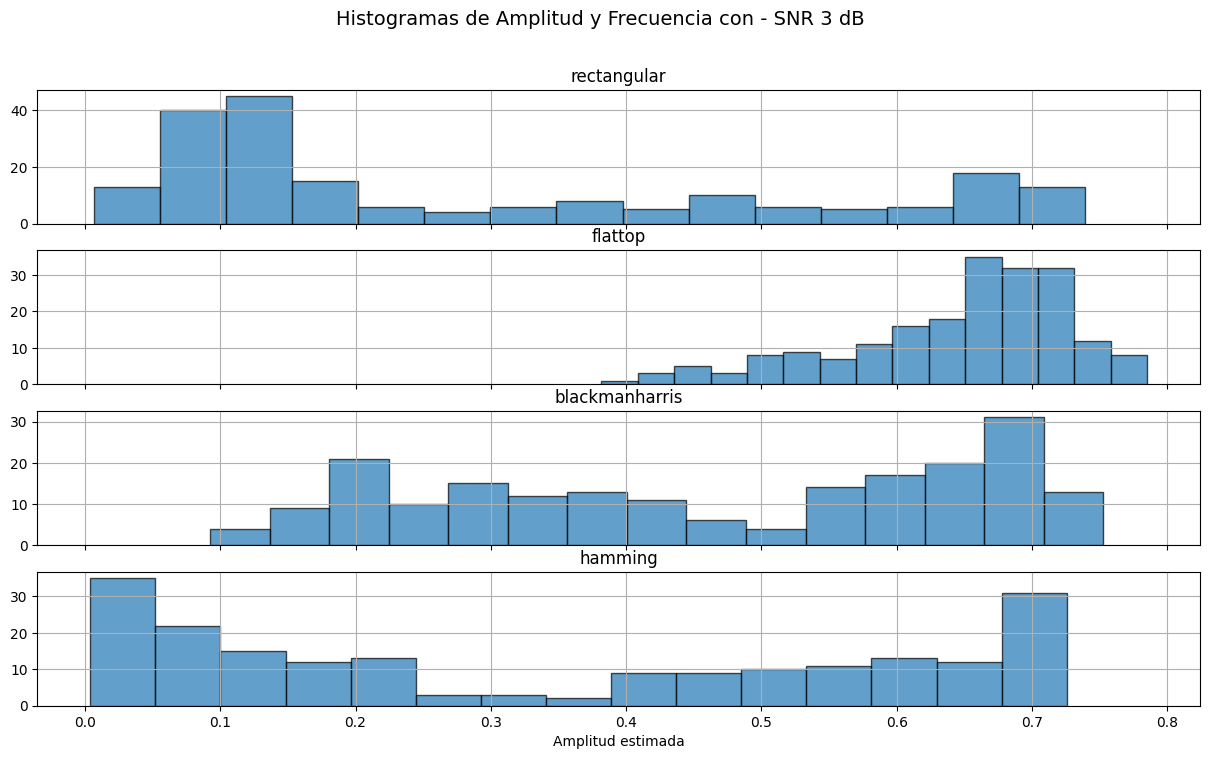

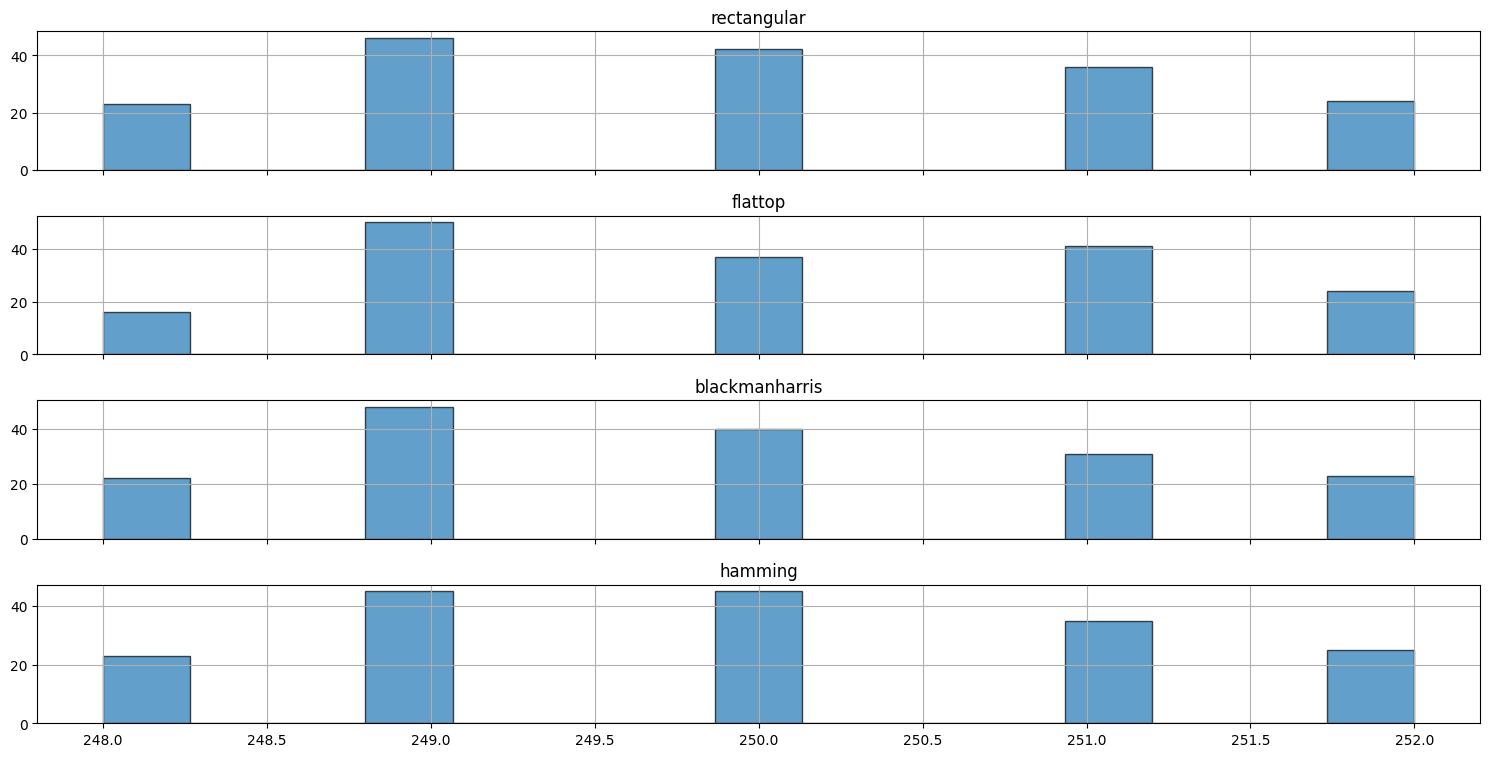

<Figure size 640x480 with 0 Axes>

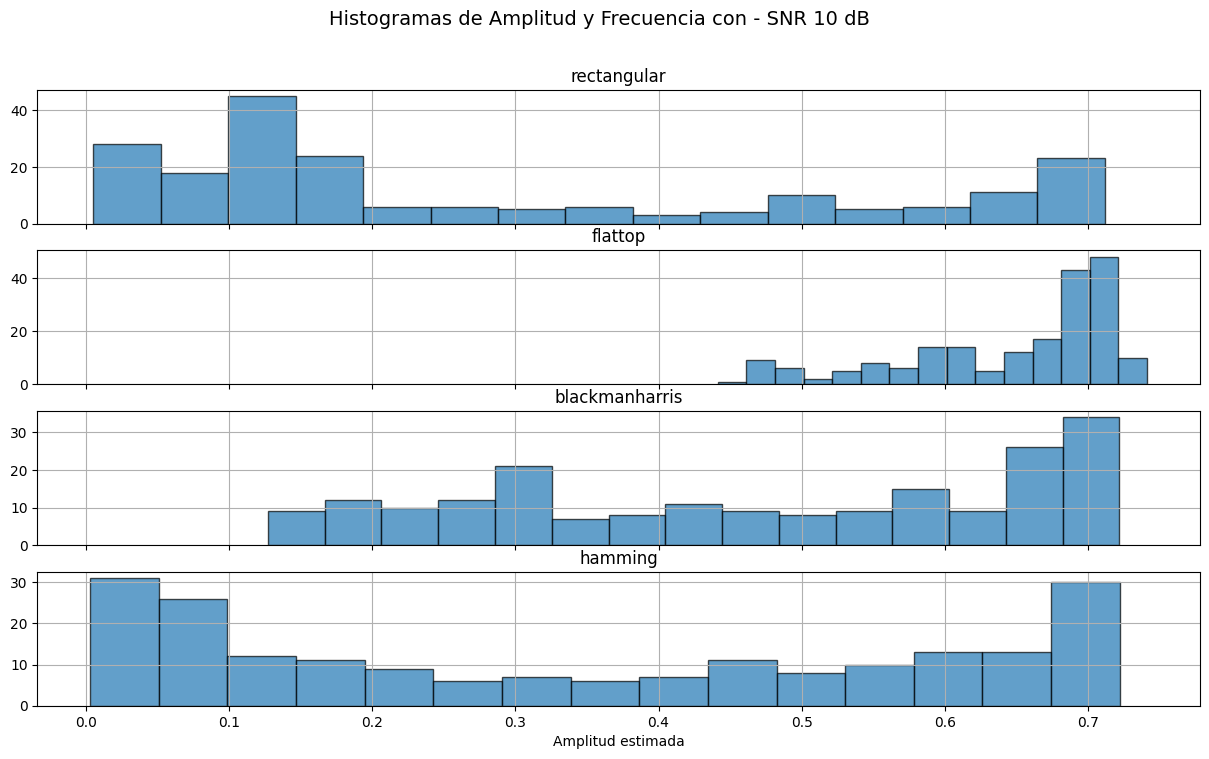

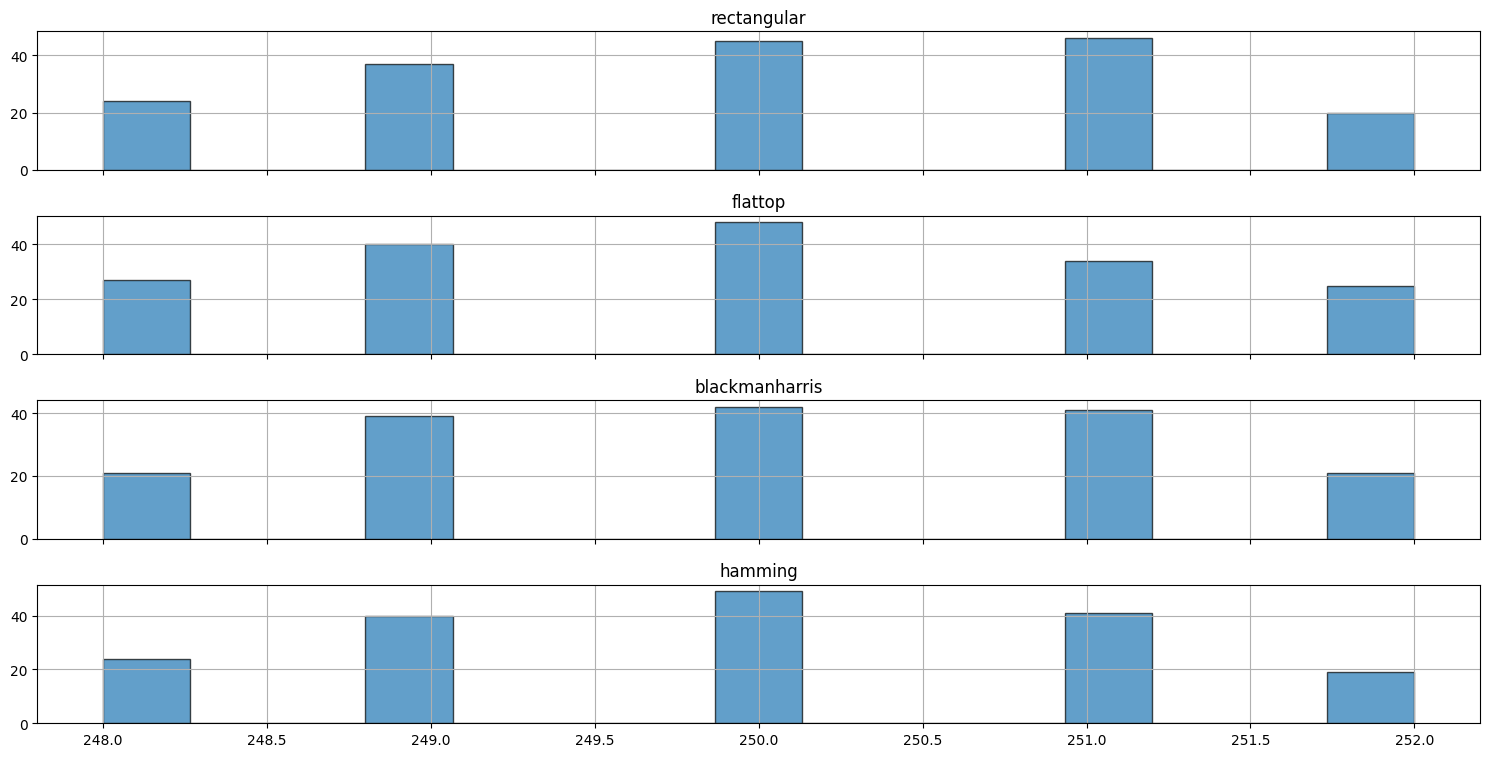

<Figure size 640x480 with 0 Axes>


Resultados para SNR = 3 dB
       Ventana  Bias_Amplitud  Var_Amplitud  Bias_Frecuencia  Var_Frecuencia
   rectangular      -1.259067      0.054781              0.0        1.586034
       flattop      -0.748652      0.006809              0.0        1.501248
blackmanharris      -0.934470      0.038035              0.0        1.580540
       hamming      -1.126062      0.067046              0.0        1.580186

Resultados para SNR = 10 dB
       Ventana  Bias_Amplitud  Var_Amplitud  Bias_Frecuencia  Var_Frecuencia
   rectangular      -1.260730      0.055249              0.0        1.514586
       flattop      -0.731992      0.005574              0.0        1.626736
blackmanharris      -0.921981      0.035520              0.0        1.521323
       hamming      -1.084297      0.065257              0.0        1.468208


In [4]:
import numpy as np
import scipy.signal as sc
import matplotlib.pyplot as plt
import pandas as pd

# Parámetros generales
N = 1000
fs = 1000
df = fs / N
R = 200                                 # realizaciones
frecuencia_central = N//4               # Medio de ancho de banda
SNRs = [3, 10]                          # dB
a0 = np.sqrt(2)                         # amplitud para P=1 W

ventanas = {
    "rectangular": np.ones(N),
    "flattop": sc.windows.flattop(N),
    "blackmanharris": sc.windows.blackmanharris(N),
    "hamming": sc.windows.hamming(N)  
}

# Vector de tiempo
tt_vector = np.arange(N)/fs

resultados = []

for SNR_dB in SNRs:
    
    # Calculo de potencia del ruido
    P_signal = a0**2 / 2
    SNR_linear = 10**(SNR_dB/10)
    pot_ruido = P_signal / SNR_linear
    
    ff_vector = np.random.uniform(-2, 2, R)         # Vector fr
    
    # Figuras
    fig_a, axes_a = plt.subplots(len(ventanas), 1, figsize=(15, 2*len(ventanas)), sharex=True)
    fig_f, axes_f = plt.subplots(len(ventanas), 1, figsize=(15, 2*len(ventanas)), sharex=True)
    
    for  i,(win_name, ventana) in enumerate( ventanas.items()):
        
        U = np.sum(ventana)/N                       # Corrección de ganancia de la ventana
        
        # Matrices de senos
        tt_columnas = tt_vector.reshape((-1,1))
        ff_filas = ff_vector.reshape((1,-1))
        TT_sen = np.tile(tt_columnas, (1, R))
        FF_sen = np.tile(ff_filas, (N, 1))
        
        # Ruido
        ruido = np.random.normal(loc=0, scale=np.sqrt(pot_ruido), size=(N,R))
        
        # Señales
        xx_sen = a0 * np.sin(2*np.pi*(frecuencia_central + FF_sen)*df*TT_sen)
        xx_sen_ruido = xx_sen + ruido
        xx_vent = xx_sen_ruido * ventana.reshape(-1,1)
        
        # FFT normalizada
        XX_sen = np.fft.fft(xx_vent, n=N, axis=0)/(N*U)
        freqs = np.fft.fftfreq(N, d=1/fs)
        
        # Estimadores
        a1_est = np.abs(XX_sen[frecuencia_central,:])
        idx_max = np.argmax(np.abs(XX_sen), axis=0)
        Omega1_est = freqs[idx_max]
        
        # Filtrar frecuencias fuera del rango [0, fs/2]
        Omega1_est = Omega1_est[(Omega1_est >= 0) & (Omega1_est <= N//2)]
        
        # Estadísticos
        bias_a1 = np.median(a1_est) - a0
        var_a1 = np.var(a1_est, ddof=1)
        
        bias_Omega1 = np.median(Omega1_est) - frecuencia_central
        var_Omega1 = np.var(Omega1_est, ddof=1)
        
        resultados.append({
            "SNR_dB": SNR_dB,  
            "Ventana": win_name,
            "Bias_Amplitud": bias_a1,
            "Var_Amplitud": var_a1,
            "Bias_Frecuencia": bias_Omega1,
            "Var_Frecuencia": var_Omega1
        })
        
        # Graficar histogramas
        axes_a[i].hist(a1_est, bins=15, edgecolor='black', alpha=0.7)
        axes_a[i].set_title(f"{win_name}")
        axes_a[i].grid(True)
        
        axes_f[i].hist(Omega1_est, bins=15, edgecolor='black', alpha=0.7)
        axes_f[i].set_title(f"{win_name}")
        axes_f[i].grid(True)
    
    axes_a[-1].set_xlabel("Amplitud estimada")
    #axes_a[-1].supylabel("Repeticiones")
    fig_a.suptitle(f"Histogramas de Amplitud y Frecuencia con - SNR {SNR_dB} dB", fontsize=14)
    plt.tight_layout(rect=[0,0,1,0.96])
    plt.show()
    
    axes_f[-1].set_xlabel("Frecuencia estimada [Hz]")
    #axes_a[-1].supylabel("Repeticiones")
    #fig_f.suptitle(f"Histogramas de Frecuencia - SNR {SNR_dB} dB", fontsize=14)
    plt.tight_layout(rect=[0,0,1,0.96])
    plt.show()

df = pd.DataFrame(resultados, columns=[
    "SNR_dB", "Ventana", "Bias_Amplitud", "Var_Amplitud",
    "Bias_Frecuencia", "Var_Frecuencia"
])

# Imprimir resultados por cada SNR 
for snr in df["SNR_dB"].unique():
    print(f"\nResultados para SNR = {snr} dB")
    print(df[df["SNR_dB"] == snr].drop(columns=["SNR_dB"]).to_string(index=False))